# Microlensing with Fink and LIA

We present preliminary results of the search for gravitational microlensing events in the ZTF alert data processed by Fink from November 01, 2019 through June 30, 2020.



<img src="img/Fink_PrimaryLogo_WEB.png" alt="drawing" width="500"/>

In [1]:
import sys
os.sys.path.insert(0, os.path.realpath('../../externals/'))

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

from skyfield.api import Topos, load
from cmb_footprint import footprint

from astropy.coordinates import SkyCoord
import astropy.units as u

from fink_science.utilities import concat_col
from fink_client.visualisation import show_stamps
from visualisation import plot_alert_data

from pyspark.sql.functions import collect_list

## Loading Fink data with Apache Spark

In order to accommodate the paradigm change introduced by the multi-TB alert data set of LSST, Fink is designed to take advantage of new technological approaches based on big data tools. We primarily use [Apache Spark](https://spark.apache.org/) to efficiently manipulate the data. Let's load all processed data by Fink between November 2019 and June 2020, stored on the VirtualData cloud:

In [2]:
# All data from November 2019 and June 2020
df = spark.read.format('parquet').load('ztf_alerts/science_reprocessed')

In [3]:
# Number of alerts that survived quality cuts
print('{} alerts pass the quality cuts'.format(df.count()))

10098333 alerts pass the quality cuts


Let's retrieve all alert coordinates:

In [4]:
df_mu = df.filter(df['mulens.class_1'] == 'ML').filter(df['mulens.class_2'] == 'ML')
radec_mu = df_mu.select('candidate.ra', 'candidate.dec').collect()
ra_mu, dec_mu = np.transpose(radec_mu)

In [5]:
print('{} alerts have been classified as ML by LIA (g&r)'.format(len(ra_mu)))

41913 alerts have been classified as ML by LIA (g&r)


and let's define some utilities for later

In [6]:
def dec2theta(dec: float) -> float:
    """ Convert Dec (deg) to theta (rad)
    """
    return np.pi / 2.0 - np.pi / 180.0 * dec

def ra2phi(ra: float) -> float:
    """ Convert RA (deg) to phi (rad)
    """
    return np.pi / 180.0 * ra

## Alert distribution on the sky

Let's inspect the sky coverage of alerts:

/opt/anaconda3-5.2.0/lib/python3.6/site-packages/healpy/projaxes.py:1194: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/opt/anaconda3-5.2.0/lib/python3.6/site-packages/healpy/projaxes.py:1153: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/opt/anaconda3-5.2.0/lib/python3.6/site-packages/healpy/projaxes.py:1153: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/opt/anaconda3-5.2.0/lib/python3.6/site-packages/healpy/projaxes.py:1153: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(

196608 196608


/opt/anaconda3-5.2.0/lib/python3.6/site-packages/healpy/projaxes.py:1194: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/opt/anaconda3-5.2.0/lib/python3.6/site-packages/healpy/projaxes.py:1153: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/opt/anaconda3-5.2.0/lib/python3.6/site-packages/healpy/projaxes.py:1153: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/opt/anaconda3-5.2.0/lib/python3.6/site-packages/healpy/projaxes.py:1153: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(

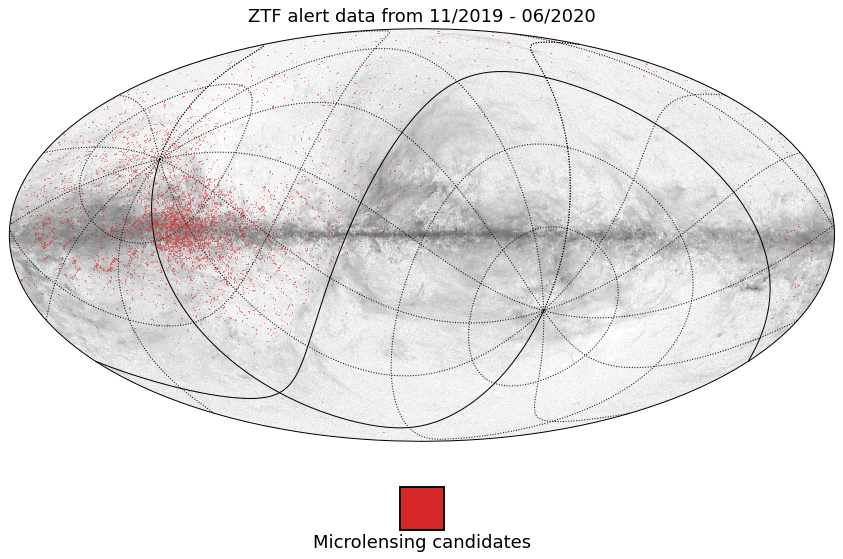

In [19]:
nside = 128
coord = 'G'
fig = plt.figure(figsize=(12, 12))

def gen_fast_map(ip_, nside):
    """ Quick and dirty projection on sky
    """
    npixel  = hp.nside2npix(nside)
    map_ = np.bincount(ip_, minlength=npixel)
    print(len(map_), 12*nside**2)
    return np.array(map_, dtype=float)

# Data is E - so otherthing than E must be transformed
if coord != 'E':
    from healpy import Rotator
    r = Rotator(coord=['E', coord])
    
    theta_mu, phi_mu = r(dec2theta(dec_mu), -ra2phi(ra_mu))
    m_mu = hp.ang2pix(nside, theta_mu, phi_mu, nest=False, lonlat=False)
else:
    m_mu = hp.ang2pix(nside, dec2theta(dec_mu), -ra2phi(ra_mu), nest=False, lonlat=False)

# Plot the background
fp = footprint.SurveyStack(
    'PLANCK-DUSTPOL', fignum=1,
    title='ZTF alert data from 11/2019 - 06/2020', 
    projection='mollweide', coord_plot=coord,
    config='/home/julien.peloton/externals/cmb_footprint/footprint.cfg'
)

hpmap_mu = gen_fast_map(m_mu, nside)
fp.superimpose_hpxmap(
    hpmap_mu, 
    label='Microlensing candidates', 
    coord_in=coord,
    color='C3'
)

## Alert candidates after cuts

Let's define some additional cuts to refine our search for microlensing events:

- Should not be flagged as SN Ia candidate by Fink
- Total history less than 50 measurements (to remove Variable stars)
- Star/Galaxy score of closest source from PS1 catalog above 0.7 (star)
- Candidates on low Galactic latitudes (|b| < 20 degrees)

In [8]:
pdf = df_mu.select([
    'objectId', 
    'candid',
    'mulens.ml_score_1', 
    'mulens.ml_score_2', 
    'cdsxmatch', 
    'timestamp', 
    'candidate.ndethist', 
    'snn_snia_vs_nonia', 
    'candidate.sgscore1', 
    'candidate.ra', 
    'candidate.dec']
).toPandas()

In [9]:
f2 = pdf.ndethist < 50
f3 = pdf.snn_snia_vs_nonia < 0.5
f4 = pdf.sgscore1 > 0.7
pdf_candidates = pdf[f2 & f3 & f4].sort_values('ml_score_1', ascending=False)

pdf_candidates['b'] = [
    SkyCoord(ra=ra*u.degree, dec=dec*u.degree).galactic.b.degree 
    for ra, dec in zip(pdf_candidates.ra.values, pdf_candidates.dec.values)
]

pdf_candidates

,objectId,candid,ml_score_1,ml_score_2,cdsxmatch,timestamp,ndethist,snn_snia_vs_nonia,sgscore1,ra,dec,b
2924,ZTF18acvqrrf,1106163284715015015,0.384282,0.337902,Unknown,2020-01-12 03:55:07.996783,49,0.409432,0.980923,59.973333,33.520611,-14.662988
30873,ZTF20aattrkw,1219354440215015006,0.364580,0.344415,Unknown,2020-05-04 08:30:23.996155,49,0.460691,0.957220,251.188132,22.513287,37.320176
36860,ZTF20aauqwzc,1226471212615015002,0.358969,0.369871,Unknown,2020-05-11 11:18:33.001902,33,0.061784,0.972625,310.656855,61.043807,11.422504
29469,ZTF20abkxllk,1301202451915015013,0.352947,0.344601,HII_G,2020-07-25 04:51:31.999671,21,0.416333,0.768083,230.610529,38.729330,56.536970
14935,ZTF20aazdsty,1277363876315015015,0.337352,0.354491,Unknown,2020-07-01 08:43:58.998735,46,0.242557,0.990833,275.630664,42.980958,23.128736
16612,ZTF20aazdsty,1274256266315015013,0.334981,0.367435,Unknown,2020-06-28 06:09:01.002256,44,0.040542,0.990833,275.630654,42.980946,23.128740
33378,ZTF20aaaacan,1123177974115010016,0.328251,0.262595,Unknown,2020-01-29 04:16:16.996820,25,0.162807,0.723875,14.697823,56.463767,-6.393390
37613,ZTF20aazdsjr,1268270263815015019,0.304638,0.314757,Unknown,2020-06-22 06:29:10.999676,32,0.464492,0.929250,274.663663,19.189872,15.646752
31108,ZTF20aaaacan,1123124914115010014,0.294992,0.262595,Unknown,2020-01-29 02:59:53.001607,24,0.134243,0.723875,14.697797,56.463789,-6.393368
39827,ZTF20aaaacan,1120118914115010007,0.294992,0.265833,Unknown,2020-01-26 02:51:13.996818,23,0.165329,0.723875,14.697812,56.463804,-6.393354


low Galactic latitudes (|b| <= 20 degree)

In [10]:
pdf_candidates[np.abs(pdf_candidates.b) < 20]

,objectId,candid,ml_score_1,ml_score_2,cdsxmatch,timestamp,ndethist,snn_snia_vs_nonia,sgscore1,ra,dec,b
2924,ZTF18acvqrrf,1106163284715015015,0.384282,0.337902,Unknown,2020-01-12 03:55:07.996783,49,0.409432,0.980923,59.973333,33.520611,-14.662988
36860,ZTF20aauqwzc,1226471212615015002,0.358969,0.369871,Unknown,2020-05-11 11:18:33.001902,33,0.061784,0.972625,310.656855,61.043807,11.422504
33378,ZTF20aaaacan,1123177974115010016,0.328251,0.262595,Unknown,2020-01-29 04:16:16.996820,25,0.162807,0.723875,14.697823,56.463767,-6.393390
37613,ZTF20aazdsjr,1268270263815015019,0.304638,0.314757,Unknown,2020-06-22 06:29:10.999676,32,0.464492,0.929250,274.663663,19.189872,15.646752
31108,ZTF20aaaacan,1123124914115010014,0.294992,0.262595,Unknown,2020-01-29 02:59:53.001607,24,0.134243,0.723875,14.697797,56.463789,-6.393368
39827,ZTF20aaaacan,1120118914115010007,0.294992,0.265833,Unknown,2020-01-26 02:51:13.996818,23,0.165329,0.723875,14.697812,56.463804,-6.393354


We are left with 4 unique objects. Among the 4, `ZTF20aazdsjr` can be removed (SN Ia) - so we are left with 3 alerts linked to 3 unique objects: 1106163284715015015 (`ZTF18acvqrrf`), 1226471212615015002 (`ZTF20aauqwzc`) and 1123177974115010016 (`ZTF20aaaacan`).

## Exploring triggers

Let's inspect the alerts that trigger a microlensing event:

In [11]:
candidates = ['1106163284715015015', '1226471212615015002', '1123177974115010016']
alerts = df.filter(df['candid'].isin(candidates)).toPandas().to_dict(orient='records')

<Figure size 576x288 with 0 Axes>

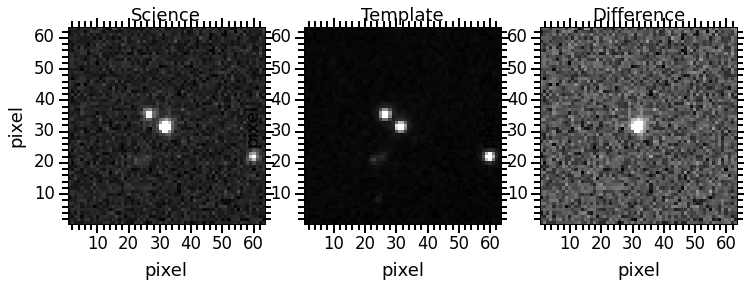

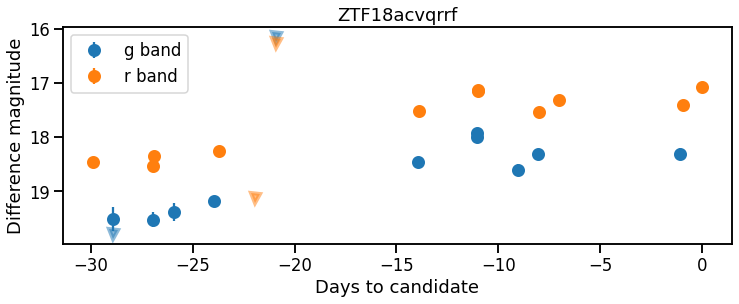

<Figure size 576x288 with 0 Axes>

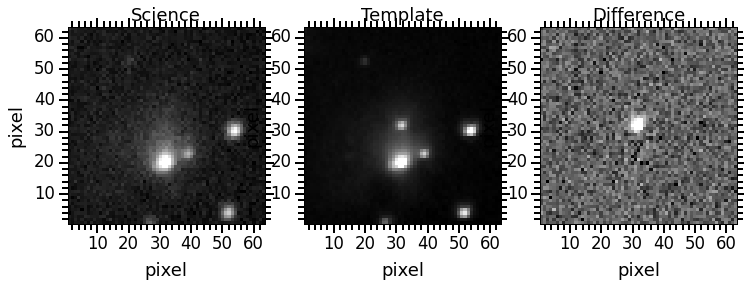

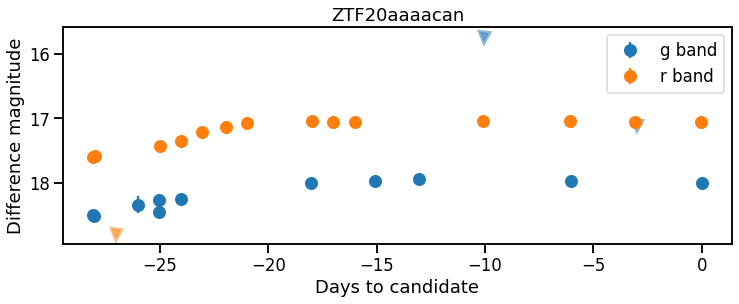

<Figure size 576x288 with 0 Axes>

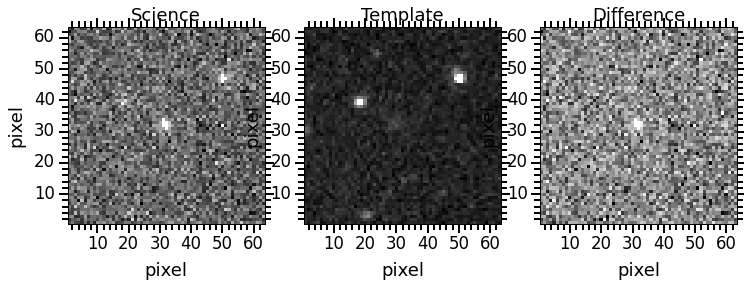

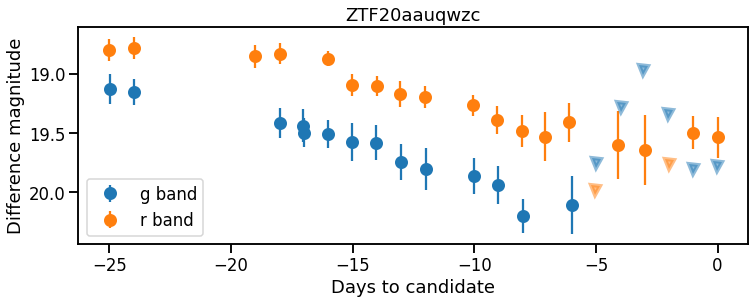

In [12]:
# to remove messages from aplpy
import logging, sys
logging.disable(sys.maxsize)

for alert in alerts:
    fig = plt.figure(figsize=(8, 4))
    plot_alert_data(alert)
    plt.show()

## Exploring full data

Let's explore aggregated lightcurves for the objects suspected of being microlensing events:

In [13]:
objects = ['ZTF18acvqrrf', 'ZTF20aauqwzc', 'ZTF20aaaacan']
df_object = df.filter(df['objectId'].isin(objects)).cache()
df_object.count()

101

In [24]:
# Required alert columns
what = ['jd', 'fid', 'magpsf', 'sigmapsf', 'diffmaglim', 'magnr', 'sigmagnr', 'magzpsci', 'isdiffpos']

# Use for creating temp name
prefix = 'c'
what_prefix = [prefix + i for i in what]

# Append temp columns with historical + current measurements
for colname in what:
    df_object = concat_col(df_object, colname, prefix=prefix)

pdf_object = df_object.toPandas()

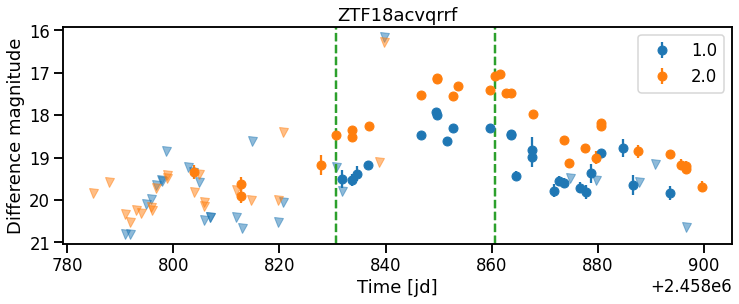

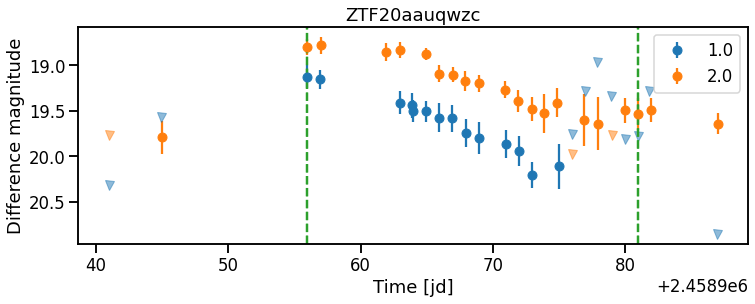

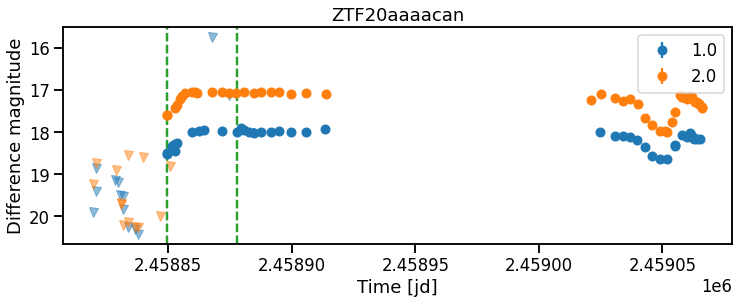

In [28]:
def extract(arrays, dtype=np.float):
    a = []
    for array in arrays:
        a = np.concatenate((a, np.array(array, dtype=dtype)))
    return a

for objectid in objects:
    fig = plt.figure(figsize=(12, 4))
    pdf = pdf_object[pdf_object.objectId == objectid]
    
    jds_ = extract(list(pdf['cjd'].to_dict().values()))
    jds_, indices = np.unique(jds_, return_index=True)
    
    
    magpsf = extract(list(pdf['cmagpsf'].to_dict().values()))[indices]
    sigmapsf = extract(list(pdf['csigmapsf'].to_dict().values()))[indices]
    diffmaglim = extract(list(pdf['cdiffmaglim'].to_dict().values()))[indices]
    fids = extract(list(pdf['cfid'].to_dict().values()))[indices]
    
    # when the alert has been triggered
    for alert in alerts:
        if alert['objectId'] == objectid:
            jd0 = alert['candidate']['jd']
            jdlast = alert['prv_candidates'][0]['jd']

    mask = magpsf != None

    for fid in np.unique(fids):
        mask_fid = fids == fid
        plt.errorbar(
            jds_[mask][mask_fid], 
            magpsf[mask_fid], 
            sigmapsf[mask_fid], 
            ls='', marker='o', label='{}'.format(fid), color='C{}'.format(int(fid)-1))
        
        masklim = magpsf[mask_fid] != magpsf[mask_fid]
        plt.plot(
            jds_[mask][mask_fid][masklim], 
            diffmaglim[mask_fid][masklim], 
            ls='', marker='v', label=None, color='C{}'.format(int(fid)-1), alpha=0.5)
        
        plt.axvline(jd0, color='C2', ls='--')
        plt.axvline(jdlast, color='C2', ls='--')

    plt.xlabel("Time [jd]")
    plt.ylabel('Difference magnitude')
    plt.title(objectid)
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()

Looking at the lightcurve, `ZTF18acvqrrf` seems a serious candidate. I do not know for the two others

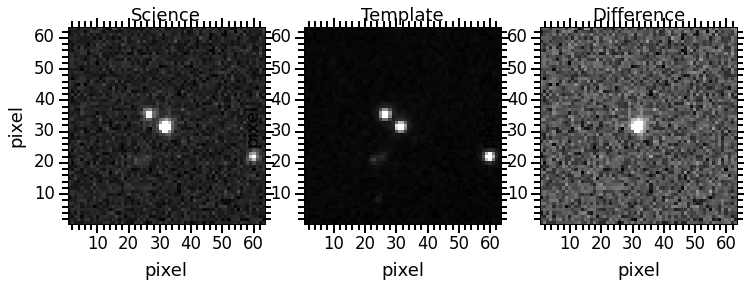

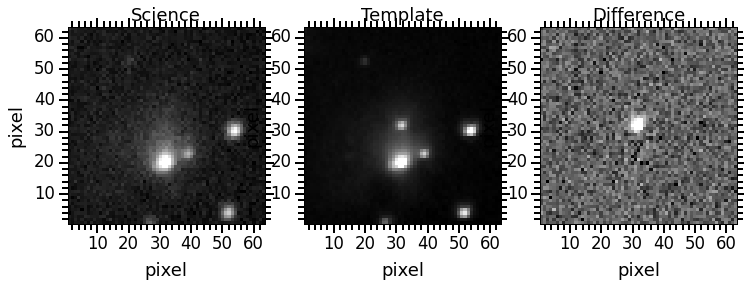

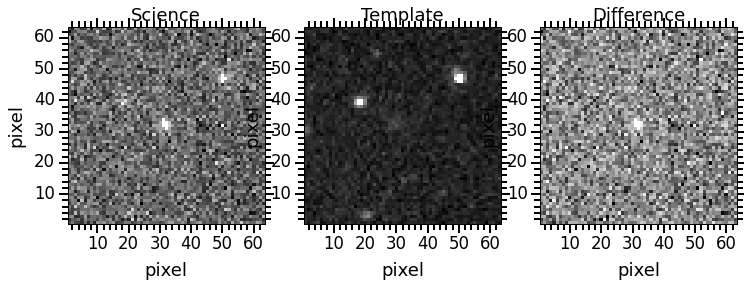

In [26]:
# to remove messages from aplpy
import logging, sys
logging.disable(sys.maxsize)

for alert in alerts:
    fig = plt.figure(figsize=(12, 4))
    show_stamps(alert, fig)
    plt.show()

## Export data

In [49]:
df_object.write.format('avro').save('microlensing_object_candidates')
#!hdfs dfs -get microlensing_object_candidates .